## v1.3 of the Sanity Test Notebook

This has the model validation tests for the paper, with the current version of the analysis & updated treatment of simulated signals.

Features:
- "bootstrap" empirical relation error (really need a new name...)
- full formalism
- M prior matching M range
- p_0(M) is uniform; p(M) matches the LRR/Petrov population distribution
- Updated simulation of signals. Now uses same prior & treatment as analysis of 'real' data
- Additionally, chirp mass and peak frequency posteriors have their means scattered proportional to their variance
- no redshift impacts or corrections

In [5]:
## point to my utils/analysis code
hbpmloc = '/mnt/c/Users/Alexander/Documents/LIGO/PM/HAYstack/'
## basic imports
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk
import scipy.stats as st
import matplotlib
import matplotlib.lines as mlines
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde as kde
from scipy.stats.mstats import mquantiles as mq
from scipy.signal import medfilt
from pesummary.core.plots.bounded_1d_kde import bounded_1d_kde
from glob import glob
import pandas as pd
import sys 
import os
import pickle
import dill

## Importing the accompanying utility and analysis files
sys.path.append(os.path.abspath(hbpmloc+'hbpm_utils/'))
from hbpm_utils import *
from importlib import reload
reload(sys.modules["hbpm_utils"])
from hbpm_utils import *
sys.path.append(hbpmloc)
from hbpm_analysis import run_analysis
reload(sys.modules["hbpm_analysis"])
from hbpm_analysis import run_analysis

## my preferred figure settings
matplotlib.rcParams['figure.figsize'] = (8.08, 5.)
matplotlib.rcParams['xtick.labelsize'] = 16.0
matplotlib.rcParams['ytick.labelsize'] = 16.0
matplotlib.rcParams['axes.labelsize'] = 18.0
matplotlib.rcParams['legend.fontsize'] = 16
matplotlib.rcParams['axes.titlesize'] = 22
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=["mediumorchid", "teal", "goldenrod","slategray"])

## Preliminaries

In [6]:
## set KDE bandwidth
bandwidth = 0.15
prior_bandwidth = bandwidth

In [7]:
## load the not-bootstrap bootstrap
## really need a new name for this
## should also make a function to do this & put the samples in the hbpm_v2 directory
coeffs = pd.read_csv(
    '/mnt/c/Users/Alexander/Documents/LIGO/PM/hbpm/analysis_2022/empirical_relation_samples/sampled_coefficients_v05.tab',
    sep=' ')
bootstrap = coeffs.to_numpy()

In [8]:
## fine grid
fs = np.linspace(1.5,4,200)
Ms = np.linspace(0.8,1.8,200)
Rs = np.linspace(9,15,200)

In [9]:
## get fpeak prior
# fprior_path = hbpmloc+'priors/fpeak_broad_noise_prior.txt'
# fprior_samples = np.loadtxt(fprior_path)
# fprior = Prior_f(fprior_samples,boundary='Reflection',kde_bandwidth=prior_bandwidth)
with open(hbpmloc+'/priors/fprior.pickle','rb') as file:
    fprior = dill.load(file)

In [10]:
## make uniform R16 prior
Rprior_kernel = st.uniform(loc=9,scale=6)

In [11]:
## set random state
rng = np.random.default_rng(170817)

## Tests

Tests needed:
- Uninformative data (doubling as our reference signalless distributions)
- Tests w/ increasing signal strength for 100 signals
- For weak signal limit, evolution w/ N_events

#### Generate Simulated 100-event Population

In [12]:
## set parameters
Rtrue = 12.5
sigma_f = 0.1
nsignal = 50
nnoise = 5000

In [13]:
## get random selection of chirp masses
## for kicks, let's use the same Mchirp prior as Petrov+2021 (which in turn is that of LRR)
N = 100
m1s = st.norm.rvs(loc=1.33,scale=0.09,size=N,random_state=rng)
m2s = st.norm.rvs(loc=1.33,scale=0.09,size=N,random_state=rng)
Mlist = calc_Mchirp(m1s,m2s)

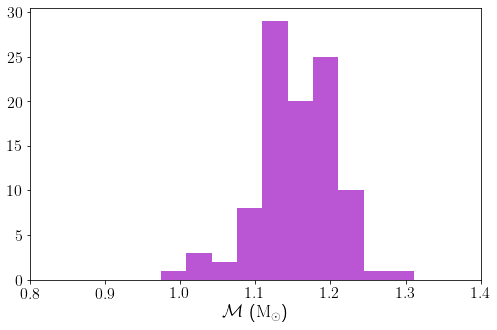

In [14]:
plt.figure()
plt.hist(Mlist)
plt.xlim(0.8,1.4)
plt.xlabel('$\mathcal{M}$ ($\mathrm{M_{\odot}}$)')
plt.show()

In order to simulate the intrinsic scatter in the $\mathrm{f_{peak}}$ posteriors, we scatter the injected $\mathrm{f_{peak}}$ posterior means with Gaussian scatter such that $\sigma_{tot}^2 = \sigma_{ER}^2 + \sigma_{noise}^2$, where $\sigma_{ER}=0.053$ kHz is the intrinsic emprical relation uncertainty and $\sigma_{noise} = \sigma_f = 0.1$ kHz, the simulated posterior standard deviation.

In [15]:
fscatter = np.sqrt(0.053**2 + sigma_f**2)

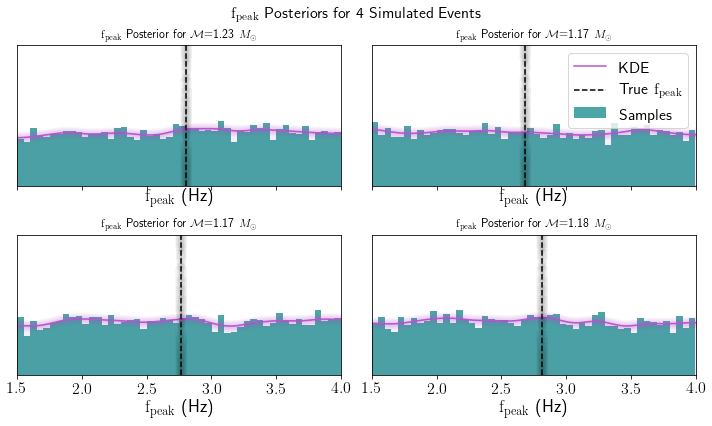

In [16]:
## generate the initial event dictionary
sim_evd = gen_simulated_eventdict(Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=fscatter,
                                  use_prior='array',prior=fprior.samples,
                                  kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                  plot='smallset',glow=True,saveto=None,showplot=True)

In [17]:
Mf_list = np.array([[sim_evd[key]['mchirp'],sim_evd[key]['ftrue']] for key in sim_evd.keys()])

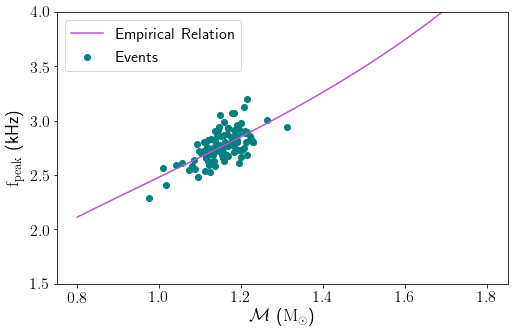

In [18]:
plt.figure()
plt.plot(Ms,empirical_relation_f(Rtrue,Ms),label='Empirical Relation')
plt.scatter(Mf_list[:,0],Mf_list[:,1],label='Events',color='teal')
plt.xlabel('$\mathcal{M}$ ($\mathrm{M_{\odot}}$)')
plt.ylabel('$\mathrm{f_{peak}}$ (kHz)')
plt.ylim(1.5,4)
plt.legend()
plt.show()

#### Uninformative Data

In [19]:
Nloop = 100
noise_likelist100 = []
for i in range(Nloop):
    print("Processing {}/{}".format(i+1,Nloop))
    sim_evd_i = gen_simulated_eventdict(Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=fscatter,
                                  use_prior='array',prior=fprior.samples,
                                  kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                  plot='none',glow=True,saveto=None,showplot=False,nosignal=True)
    test_likes_i = get_multievent_likelihoods(Rs,Ms,sim_evd_i,Mchirp_type='simulated',fprior=fprior,
                                              Mprior=st.uniform(loc=0,scale=5),Mpop_prior=st.norm(loc=1.33,scale=0.09),
                                              Mchirp_scaling='none',Mchirp_scatter='match',
                                              verbose=False,bootstrap=bootstrap)
    noise_likelist100.append(test_likes_i)
# orchid_line = mlines.Line2D([], [], color='mediumorchid',alpha=0.7,label='Weak-Signal $\mathrm{R_{1.6}}$ Posteriors')

Processing 1/100


100%|==========| 100/100 [04:36<00:00,  2.76s/it]


Processing 2/100


100%|==========| 100/100 [04:11<00:00,  2.51s/it]


Processing 3/100


100%|==========| 100/100 [04:11<00:00,  2.51s/it]


Processing 4/100


100%|==========| 100/100 [04:13<00:00,  2.54s/it]


Processing 5/100


100%|==========| 100/100 [03:55<00:00,  2.36s/it]


Processing 6/100


100%|==========| 100/100 [04:08<00:00,  2.49s/it]


Processing 7/100


100%|==========| 100/100 [04:16<00:00,  2.57s/it]


Processing 8/100


100%|==========| 100/100 [04:13<00:00,  2.53s/it]


Processing 9/100


100%|==========| 100/100 [04:05<00:00,  2.45s/it]


Processing 10/100


100%|==========| 100/100 [20:47<00:00, 12.48s/it]


Processing 11/100


100%|==========| 100/100 [04:39<00:00,  2.79s/it]


Processing 12/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 13/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 14/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 15/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 16/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 17/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 18/100


100%|==========| 100/100 [03:54<00:00,  2.34s/it]


Processing 19/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 20/100


100%|==========| 100/100 [03:53<00:00,  2.34s/it]


Processing 21/100


100%|==========| 100/100 [03:52<00:00,  2.32s/it]


Processing 22/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 23/100


100%|==========| 100/100 [03:52<00:00,  2.32s/it]


Processing 24/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 25/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 26/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 27/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 28/100


100%|==========| 100/100 [03:52<00:00,  2.32s/it]


Processing 29/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 30/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 31/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 32/100


100%|==========| 100/100 [03:53<00:00,  2.34s/it]


Processing 33/100


100%|==========| 100/100 [03:54<00:00,  2.34s/it]


Processing 34/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 35/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 36/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 37/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 38/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 39/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 40/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 41/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 42/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 43/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 44/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 45/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 46/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 47/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 48/100


100%|==========| 100/100 [03:54<00:00,  2.34s/it]


Processing 49/100


100%|==========| 100/100 [03:53<00:00,  2.34s/it]


Processing 50/100


100%|==========| 100/100 [03:53<00:00,  2.34s/it]


Processing 51/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 52/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 53/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 54/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 55/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 56/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 57/100


100%|==========| 100/100 [03:53<00:00,  2.34s/it]


Processing 58/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 59/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 60/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 61/100


100%|==========| 100/100 [03:52<00:00,  2.32s/it]


Processing 62/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 63/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 64/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 65/100


100%|==========| 100/100 [03:53<00:00,  2.34s/it]


Processing 66/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 67/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 68/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 69/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 70/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 71/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 72/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 73/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 74/100


100%|==========| 100/100 [03:52<00:00,  2.32s/it]


Processing 75/100


100%|==========| 100/100 [03:52<00:00,  2.32s/it]


Processing 76/100


100%|==========| 100/100 [03:52<00:00,  2.32s/it]


Processing 77/100


100%|==========| 100/100 [03:52<00:00,  2.32s/it]


Processing 78/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 79/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 80/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 81/100


100%|==========| 100/100 [03:52<00:00,  2.32s/it]


Processing 82/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 83/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 84/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 85/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 86/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 87/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 88/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 89/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 90/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 91/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 92/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 93/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 94/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 95/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 96/100


100%|==========| 100/100 [03:52<00:00,  2.32s/it]


Processing 97/100


100%|==========| 100/100 [03:52<00:00,  2.32s/it]


Processing 98/100


100%|==========| 100/100 [03:53<00:00,  2.33s/it]


Processing 99/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


Processing 100/100


100%|==========| 100/100 [03:52<00:00,  2.33s/it]


In [20]:
noise_postlist100 = []
for like_i in noise_likelist100:
    noise_postlist100.append(get_posterior(Rs,get_aggregate_likelihood(like_i),Rprior_kernel))

In [21]:
# np.savetxt('./paper_data/model_validation_data/noise_only_R16post_100x100events.txt',noise_postlist100)

#### For convenience sake, we can directly load the results of the previous section:

In [19]:
noise_postlist100 = np.genfromtxt('./paper_data/model_validation_data/noise_only_R16post_100x100events.txt')
Nloop = len(noise_postlist100)
## uniform prior so post == like
## structure allows for easy handling by get_aggregate_likelihood()
noise_likelist = [[like_i] for like_i in list(noise_postlist100)]

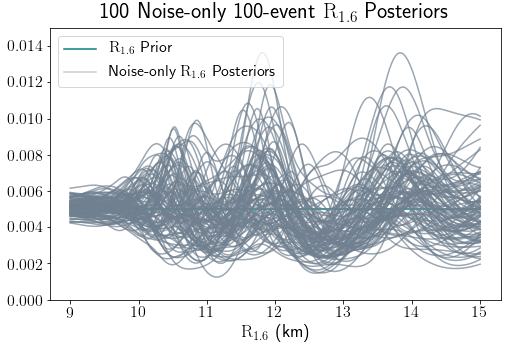

In [20]:
plt.figure()
plt.xlabel('$\mathrm{R_{1.6}}$ (km)')
plt.title('{} Noise-only '.format(Nloop)+'100-event $\mathrm{R_{1.6}}$ Posteriors')
# plt.axvline(Rtrue,ls='--',color='k',label='True $\mathrm{R_{1.6}}$')
plt.plot(Rs,Rprior_kernel.pdf(Rs)/np.sum(Rprior_kernel.pdf(Rs)),label='$\mathrm{R_{1.6}}$ Prior',color='teal')
for post_i in noise_postlist100:
    plt.plot(Rs,post_i,color='slategray',alpha=0.7,label='_nolegend_')
#     plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(like_i),Rprior_kernel),color='slategray',
#              alpha=0.7,label='_nolegend_')
grey_line = mlines.Line2D([], [], color='slategray',alpha=0.4,label='Noise-only $\mathrm{R_{1.6}}$ Posteriors')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles+[grey_line],loc='upper left')
# plt.gca().set_yticks([])
plt.ylim(0,0.015)
# plt.savefig('./figures/modval_noiseonly.pdf',bbox_inches='tight')
# plt.savefig('./figures/modval_noiseonly.png',bbox_inches='tight')
plt.show()

#### Highly-informative data

Again, not sure if this will make it in the final draft, but it's good to have.

In [21]:
## set parameters
Rtrue = 12.5
sigma_f = 0.1
nsignal = 5000
nnoise = 0

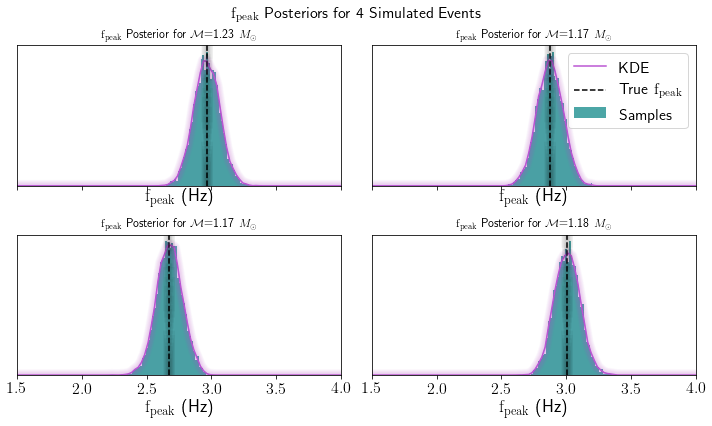

In [22]:
## make sure gen_simulated_eventdict() works lol
sim_evd_highSNR = gen_simulated_eventdict(Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=fscatter,
                                  use_prior='array',prior=fprior.samples,
                                  kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                  plot='smallset',glow=True,saveto=None,showplot=True)

100%|==========| 100/100 [04:03<00:00,  2.44s/it]


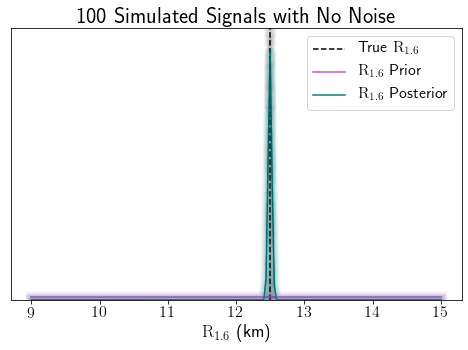

In [23]:
test_likes_highSNR = get_multievent_likelihoods(Rs,Ms,sim_evd_highSNR,Mchirp_type='simulated',fprior=fprior,
                           Mprior=st.uniform(loc=0,scale=5),Mpop_prior=st.norm(loc=1.33,scale=0.09),
                                                Mchirp_scaling='none',Mchirp_scatter='match',
                                                verbose=False,bootstrap=bootstrap)
plot_aggregate_posterior(Rs,test_likes_highSNR,Rprior_kernel,diagnostics=False,Rtrue=Rtrue,
                     title='100 Simulated Signals with No Noise',
                     legend_anchor=None,saveto=None,
                     glow=True,ax=None,Rticks=None,showplot=True)

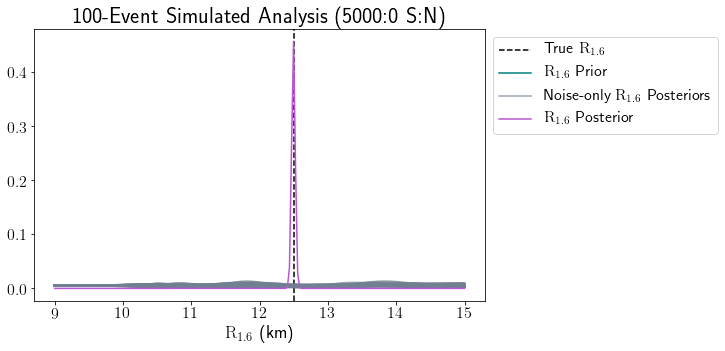

In [24]:
plt.figure()
plt.xlabel('$\mathrm{R_{1.6}}$ (km)')
plt.title('{}-Event Simulated Analysis (5000:0 S:N)'.format(100))
plt.axvline(Rtrue,ls='--',color='k',label='True $\mathrm{R_{1.6}}$')
plt.plot(Rs,Rprior_kernel.pdf(Rs)/np.sum(Rprior_kernel.pdf(Rs)),label='$\mathrm{R_{1.6}}$ Prior',color='teal')
for like_i in noise_likelist:
    plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(like_i),Rprior_kernel),color='slategray',
             alpha=0.7,label='_nolegend_')
plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(test_likes_highSNR),Rprior_kernel),color='mediumorchid',label='_nolegend_')
orchid_line = mlines.Line2D([], [], color='mediumorchid',
                            label='$\mathrm{R_{1.6}}$'+' Posterior')
teal_line = mlines.Line2D([], [], color='slategray',alpha=0.7,label='Noise-only $\mathrm{R_{1.6}}$ Posteriors')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles+[teal_line,orchid_line],bbox_to_anchor=(1,1))
# plt.gca().set_yticks([])
plt.show()

Looks gucci, stanley tucci. 

Investigate how we scale with $N_s : N_n$:

In [25]:
## set parameters
Rtrue = 12.5
sigma_f = 0.1
nsignal = 1
nnoise = 5000

In [26]:
countlist = [1,5,10,25,50,100]
SNR_metalist = []
dict_list = []
for i, count in enumerate(countlist):
    print("Analyzing dataset {}/{}...".format(i+1,len(countlist)))
    nsignal = count
    sim_evd_i = gen_simulated_eventdict(Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=fscatter,
                                  use_prior='array',prior=fprior.samples,
                                  kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                  plot='smallset',glow=True,saveto=None,showplot=False)
    dict_list.append(sim_evd_i)
    test_likes_i = get_multievent_likelihoods(Rs,Ms,sim_evd_i,Mchirp_type='simulated',fprior=fprior,
                           Mprior=st.uniform(loc=0,scale=5),Mpop_prior=st.norm(loc=1.33,scale=0.09),
                                              Mchirp_scaling='none',Mchirp_scatter='match',
                                              verbose=False,bootstrap=bootstrap)
    SNR_metalist.append(test_likes_i)

Analyzing dataset 1/6...


100%|==========| 100/100 [04:07<00:00,  2.47s/it]


Analyzing dataset 2/6...


100%|==========| 100/100 [04:00<00:00,  2.40s/it]


Analyzing dataset 3/6...


100%|==========| 100/100 [04:03<00:00,  2.44s/it]


Analyzing dataset 4/6...


100%|==========| 100/100 [04:04<00:00,  2.44s/it]


Analyzing dataset 5/6...


100%|==========| 100/100 [04:05<00:00,  2.45s/it]


Analyzing dataset 6/6...


100%|==========| 100/100 [04:07<00:00,  2.47s/it]


In [27]:
SNR_metadict = {}
for i, count in enumerate(countlist):
    SNR_metadict[str(count)] = {}
    SNR_metadict[str(count)]['event_dict'] = dict_list[i]
    SNR_metadict[str(count)]['likelihoods'] = SNR_metalist[i]

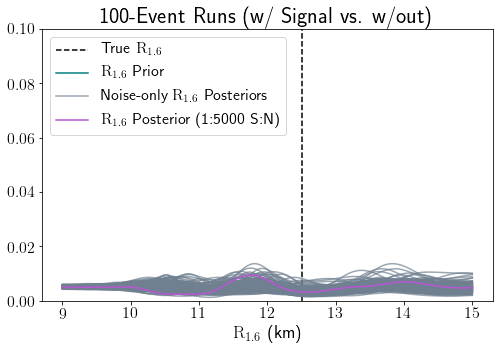

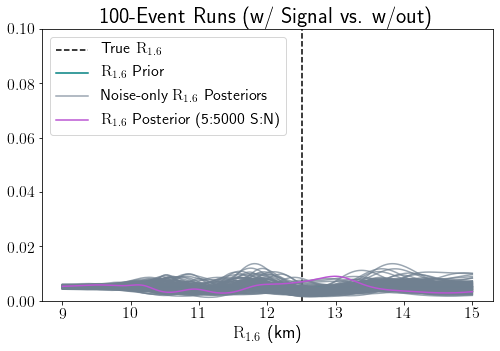

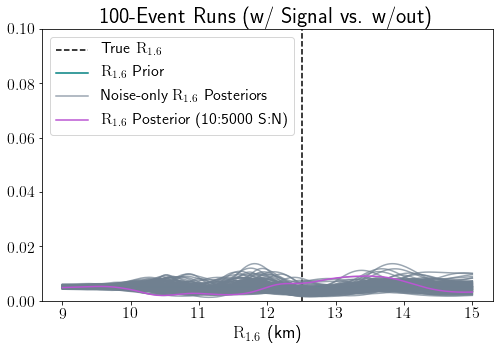

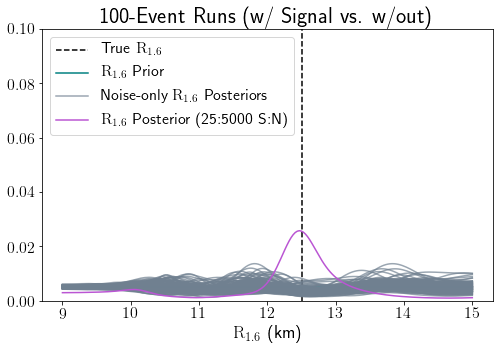

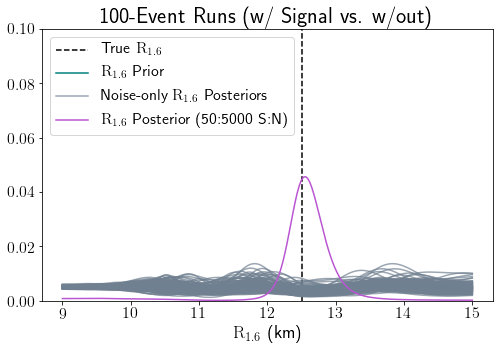

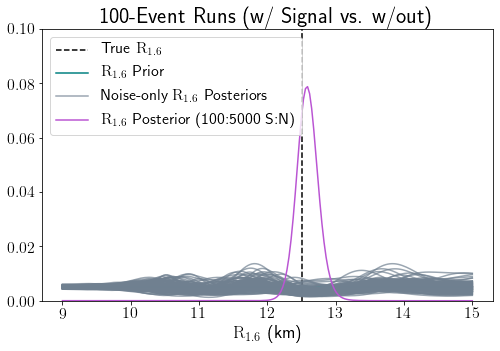

In [28]:
for i, count in enumerate([1,5,10,25,50,100]):
    plt.figure()
    plt.xlabel('$\mathrm{R_{1.6}}$ (km)')
    plt.title('{}-Event Runs (w/ Signal vs. w/out)'.format(100))
    plt.axvline(Rtrue,ls='--',color='k',label='True $\mathrm{R_{1.6}}$')
    plt.plot(Rs,Rprior_kernel.pdf(Rs)/np.sum(Rprior_kernel.pdf(Rs)),label='$\mathrm{R_{1.6}}$ Prior',color='teal')
    for like_i in noise_likelist:
        plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(like_i),Rprior_kernel),color='slategray',
                 alpha=0.7,label='_nolegend_')
    plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(SNR_metalist[i]),Rprior_kernel),color='mediumorchid',label='_nolegend_')
    orchid_line = mlines.Line2D([], [], color='mediumorchid',
                                label='$\mathrm{R_{1.6}}$'+' Posterior ({}:{} S:N)'.format(count,nnoise))
    gray_line = mlines.Line2D([], [], color='slategray',alpha=0.7,label='Noise-only $\mathrm{R_{1.6}}$ Posteriors')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles=handles+[gray_line,orchid_line],loc='upper left')#bbox_to_anchor=(1,1))
#     plt.gca().set_yticks([])
    plt.ylim(0,0.1)
    plt.show()

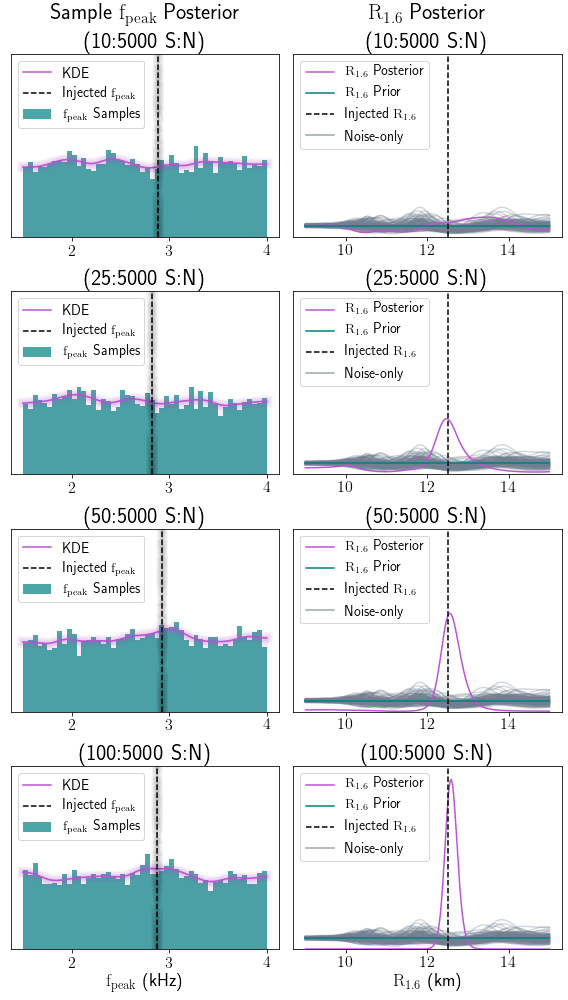

In [33]:
# idxs = [1,2,3,4]
idxs = [2,3,4,5]
scount_list = [1,5,10,25,50,100]
fig, axes = plt.subplots(len(idxs),2,figsize=(8,14),sharey=False)#,gridspec_kw={"height_ratios":[0.001,1,1,1,1]})
# axes[0,0].axis('off')
# axes[0,0].set_title("Sample $\mathrm{f_{peak}}$ Posterior")
# axes[0,1].axis('off')
# axes[0,1].set_title("$\mathrm{R_{1.6}}$ Posterior")
# for (i, count), sim_evd_i in zip(enumerate([scount_list[ii] for ii in idx]),[dict_list[ii] for ii in idx]):
for i, idx in enumerate(idxs):
    count = scount_list[idx]
    sim_evd_i = dict_list[idx]
    ax1 = axes[i][0]
    ax2 = axes[i][1]
    firstkey = '1.23-1'
    samples_i1 = sim_evd_i[firstkey]['fchains']
    ftrue_i1 = sim_evd_i[firstkey]['ftrue']
    kde_i1 = sim_evd_i[firstkey]['kde']
    ax1.hist(samples_i1,density=True,bins=50,color='teal',alpha=0.7,label='$\mathrm{f_{peak}}$ Samples')
    ax1.plot(fs,kde_i1.pdf(fs),color='mediumorchid',label='KDE')
    ax1.axvline(ftrue_i1,color='k',ls='--',label='Injected $\mathrm{f_{peak}}$')
    ax1.legend(loc='upper left',fontsize=14)
    ax1.set_ylim(0,1)
    ax1.set_yticks([])
    if i==0:
        ax1.set_title("Sample $\mathrm{f_{peak}}$ Posterior\n"+'({}:{} S:N)'.format(count,nnoise))
    else:
        ax1.set_title('({}:{} S:N)'.format(count,nnoise))
    mplcyberpunk.add_glow_effects(ax1)
    for like_i in noise_likelist:
        ax2.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(like_i),Rprior_kernel),color='slategray',
                 alpha=0.3,label='_nolegend_')
    ax2.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(SNR_metalist[idx]),Rprior_kernel),color='mediumorchid',
             label='$\mathrm{R_{1.6}}$ Posterior')
    ax2.plot(Rs,Rprior_kernel.pdf(Rs)/np.sum(Rprior_kernel.pdf(Rs)),color='teal',label='$\mathrm{R_{1.6}}$ Prior')
    ax2.axvline(Rtrue,color='k',ls='--',label='Injected $\mathrm{R_{1.6}}$')
#     orchid_line = mlines.Line2D([], [], color='mediumorchid',
#                                 label='$\mathrm{R_{1.6}}$'+' Posterior'.format(count,nnoise))
    gray_line = mlines.Line2D([], [], color='slategray',alpha=0.7,label='Noise-only')
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles=handles+[gray_line],loc='upper left',fontsize=14)
    ax2.set_ylim(0,0.085)
    if i==0:
        ax2.set_title("$\mathrm{R_{1.6}}$ Posterior\n"+'({}:{} S:N)'.format(count,nnoise))
    else:
        ax2.set_title('({}:{} S:N)'.format(count,nnoise))
    ax2.set_yticks([])
    if idx == idxs[-1]:
        ax1.set_xlabel('$\mathrm{f_{peak}}$ (kHz)')
        ax2.set_xlabel('$\mathrm{R_{1.6}}$ (km)')
plt.tight_layout()
plt.savefig('./figures/mod_val_sidebyside_10panel.pdf',bbox_inches='tight')
plt.savefig('./figures/mod_val_sidebyside_10panel.png',bbox_inches='tight')
# plt.show()

In [34]:
for ii in idxs:
    print('N_s = {}'.format(scount_list[ii]))
    get_post_stats(get_posterior(Rs,get_aggregate_likelihood(SNR_metalist[ii]),Rprior_kernel),Rs,latex=True)

N_s = 10
$\R=12.31^{+2.45}_{-3.16}$
N_s = 25
$\R=12.13^{+2.14}_{-2.88}$
N_s = 50
$\R=12.50^{+0.90}_{-2.57}$
N_s = 100
$\R=12.59^{+0.33}_{-0.31}$


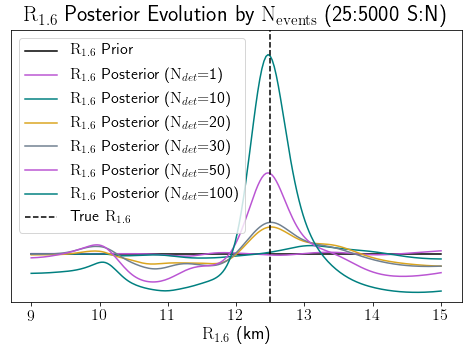

In [36]:
plot_posterior_by_Nevents(Rs,SNR_metalist[-3],Rprior_kernel,[1,10,20,30,50,100],Rtrue=Rtrue,legend_loc='upper left',
                             title='$\mathrm{R_{1.6}}$ Posterior Evolution by $\mathrm{N_{events}}$'+' ({}:{} S:N)'.format(25,nnoise))

In [37]:
## save data
with open('./paper_data/model_validation_data/100event_synthetic_multiSNR.pickle','wb') as file:
    dill.dump(SNR_metadict,file)

## Check N-event scaling of C.I.s

### 68% C.I. Width

In [38]:
scaling_dict68 = {}
for scount,(j,likelist) in zip(countlist,enumerate(SNR_metalist)):
    CL_arr = np.zeros((100,3))
    for i in range(100):
        CL_arr[i,:] = get_post_stats(get_posterior(Rs,get_aggregate_likelihood(likelist[:i+1]),Rprior_kernel),
                                     Rs,latex=False,verbose=False,bounds=(0.16,0.74))
    scaling_dict68[str(scount)] = CL_arr

In [39]:
start = (scaling_dict68[str(scount)][:,2] - scaling_dict68[str(scount)][:,1])[0]

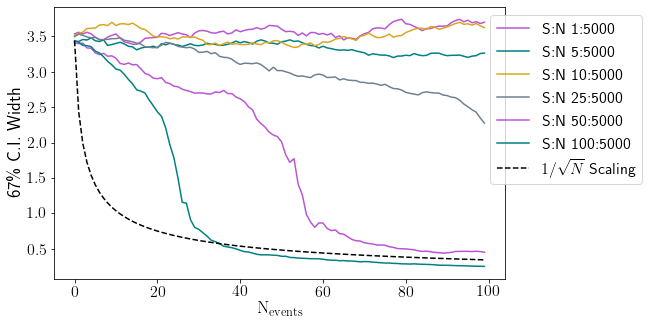

In [40]:
plt.figure()
for i, scount in enumerate(countlist):
    plt.plot(scaling_dict68[str(scount)][:,2] - scaling_dict68[str(scount)][:,1],label="S:N {}:5000".format(scount))
plt.plot(start/np.sqrt(np.linspace(1,100,100)),label="$1/\sqrt{N}$ Scaling",color='k',ls='--')
plt.legend(bbox_to_anchor=(0.95,1))
plt.ylabel("67\% C.I. Width")
plt.xlabel("$\mathrm{N_{events}}$")
plt.show()
    

### 95% C.I. Width

In [41]:
scaling_dict95 = {}
for scount,(j,likelist) in zip(countlist,enumerate(SNR_metalist)):
    CL_arr = np.zeros((100,3))
    for i in range(100):
        CL_arr[i,:] = get_post_stats(get_posterior(Rs,get_aggregate_likelihood(likelist[:i+1]),Rprior_kernel),
                                     Rs,latex=False,verbose=False,bounds=(0.025,0.975))
    scaling_dict95[str(scount)] = CL_arr
        

In [42]:
start = (scaling_dict95[str(scount)][:,2] - scaling_dict95[str(scount)][:,1])[0]

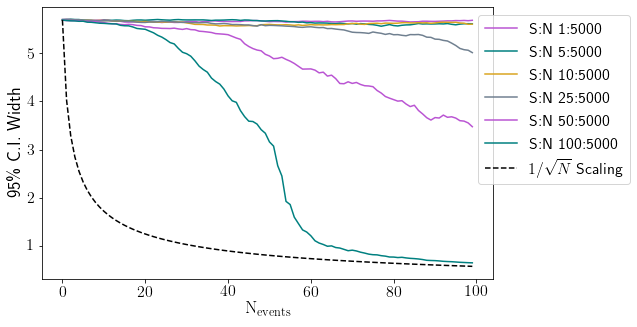

In [43]:
plt.figure()
for i, scount in enumerate(countlist):
    plt.plot(scaling_dict95[str(scount)][:,2] - scaling_dict95[str(scount)][:,1],label="S:N {}:5000".format(scount))
plt.plot(start/np.sqrt(np.linspace(1,100,100)),label="$1/\sqrt{N}$ Scaling",color='k',ls='--')
plt.legend(bbox_to_anchor=(0.95,1))
plt.ylabel("95\% C.I. Width")
plt.xlabel("$\mathrm{N_{events}}$")
plt.show()
    

## Demo: applicability across parameter space

In [44]:
## set parameters
sigma_f = 0.1
nsignal = 50
nnoise = 5000

In [45]:
Rinj_metalist = []
Rinj_dictlist = []
for R in [10,11,12,13,14]:#[9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5]:
    Rtrue = R
    sim_evd_i = gen_simulated_eventdict(Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=fscatter,
                                  use_prior='array',prior=fprior.samples,
                                  kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                  plot='smallset',glow=True,saveto=None,showplot=False)
    Rinj_dictlist.append(sim_evd_i)
    test_likes_i = get_multievent_likelihoods(Rs,Ms,sim_evd_i,Mchirp_type='simulated',fprior=fprior,
                           Mprior=st.uniform(loc=0,scale=5),Mpop_prior=st.norm(loc=1.33,scale=0.09),
                                              Mchirp_scaling='none',Mchirp_scatter='match',
                                              verbose=False,bootstrap=bootstrap)
    Rinj_metalist.append(test_likes_i)

100%|==========| 100/100 [04:12<00:00,  2.52s/it]


In [46]:
## package and save
Rinj_metadict = {}
for i, R in enumerate([10,11,12,13,14]):
    Rinj_metadict[str(R)] = {}
    Rinj_metadict[str(R)]['event_dict'] = Rinj_dictlist[i]
    Rinj_metadict[str(R)]['likelihoods'] = Rinj_metalist[i]
## save data
with open('./paper_data/model_validation_data/100event_synthetic_multiR.pickle','wb') as file:
    dill.dump(Rinj_metadict,file)

In [47]:
## load data
with open('./paper_data/model_validation_data/100event_synthetic_multiR.pickle','rb') as file:
    Rinj_metadict_loaded = dill.load(file)

In [48]:
## unpackage
Rlist = [10,11,12,13,14]
Rinj_metalist_ld = []
for i in Rlist:
    Rinj_metalist_ld.append(Rinj_metadict_loaded[str(i)]['likelihoods'])

10
R_1.6 = 11.00 (+3.33,-1.59) km
11
R_1.6 = 11.13 (+0.72,-0.82) km
12
R_1.6 = 12.02 (+0.41,-0.36) km
13
R_1.6 = 13.09 (+0.72,-1.28) km
14
R_1.6 = 14.02 (+0.74,-0.67) km


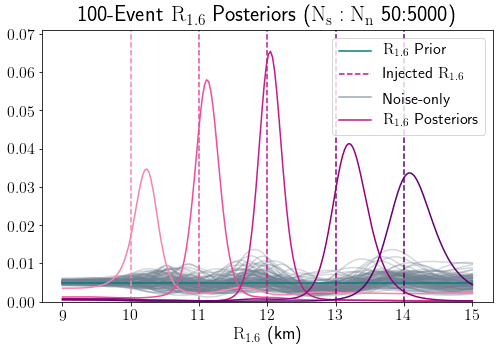

In [49]:
R2plot = [10,11,12,13,14]
plt.figure()
plt.xlabel('$\mathrm{R_{1.6}}$ (km)')
plt.title('100-Event $\mathrm{R_{1.6}}$ Posteriors ($\mathrm{N_s:N_n}$ 50:5000)')
for like_i in noise_likelist:
    plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(like_i),Rprior_kernel),color='slategray',
             alpha=0.3,label='_nolegend_')
plt.plot(Rs,Rprior_kernel.pdf(Rs)/np.sum(Rprior_kernel.pdf(Rs)),label='$\mathrm{R_{1.6}}$ Prior',color='teal')
cmap = matplotlib.cm.get_cmap('RdPu')
# for R in Rs2:
#     colnum = (R - Rs2.min())/(Rs2.max() - Rs2.min())
#     plt.plot(Ms2,empirical_relation_f(R,Ms2),label='$\mathrm{R_{1.6}}$'+' = {:0.2f} (V)'.format(R),color='slategrey')
#     plt.plot(Ms2,empirical_relation_new(R,Ms2),label='$\mathrm{R_{1.6}}$'+' = {:0.2f} (J)'.format(R),color=cmap(colnum))
for i, R in enumerate([10,11,12,13,14]):#[9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5]):
    if R in R2plot:
        print(R)
        get_post_stats(get_posterior(Rs,get_aggregate_likelihood(Rinj_metalist_ld[i]),Rprior_kernel),Rs,bounds=(0.05,0.95))
#         colnum = (R - R2plot.min())/(R2plot.max() - R2plot.min())
        colnum = (R - 6.5)/(8)
        plt.axvline(R,ls='--',color=cmap(colnum),label='__nolabel__')
        plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(Rinj_metalist_ld[i]),Rprior_kernel),
                 color=cmap(colnum),label='_nolegend_')
# orchid_line = mlines.Line2D([], [], color='mediumorchid',
#                             label='$\mathrm{R_{1.6}}$'+' Posterior ({}:{} S:N)'.format(25,nnoise))
gray_line = mlines.Line2D([], [], color='slategray',alpha=0.7,label='Noise-only')
cmap_solid = mlines.Line2D([], [], color=cmap(0.7),label='$\mathrm{R_{1.6}}$ Posteriors')
cmap_dashed = mlines.Line2D([], [], color=cmap(0.7),ls='--',label='Injected $\mathrm{R_{1.6}}$')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles+[cmap_dashed,gray_line,cmap_solid],loc='upper right')#bbox_to_anchor=(1,1))
# plt.gca().set_yticks([])
# plt.axvline(R,ls='--',color='k',label='True $\mathrm{R_{1.6}}$'
plt.ylim(0,0.071)
# plt.savefig('./figures/mod_val_Rrange.pdf',bbox_inches='tight')
# plt.savefig('./figures/mod_val_Rrange.png',bbox_inches='tight')
plt.show()

# Deep Search
High-N repeat of a few earlier tests.

#### Generate Events

In [55]:
## set parameters
Rtrue = 12.5
sigma_f = 0.1
nsignal = 25
nnoise = 5000

In [56]:
## get random selection of chirp masses
## for kicks, let's use the same Mchirp prior as Petrov+2021 (which in turn is that of LRR)
N = 2000
m1s = st.norm.rvs(loc=1.33,scale=0.09,size=N,random_state=rng)
m2s = st.norm.rvs(loc=1.33,scale=0.09,size=N,random_state=rng)
Mlist = calc_Mchirp(m1s,m2s)

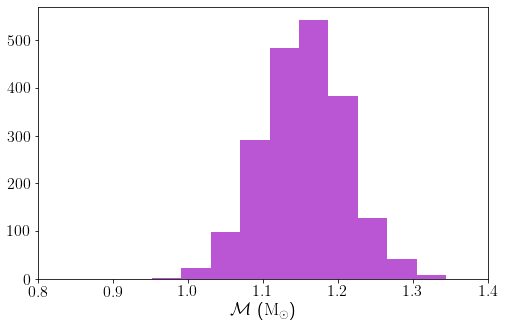

In [57]:
plt.figure()
plt.hist(Mlist)
plt.xlim(0.8,1.4)
plt.xlabel('$\mathcal{M}$ ($\mathrm{M_{\odot}}$)')
plt.show()

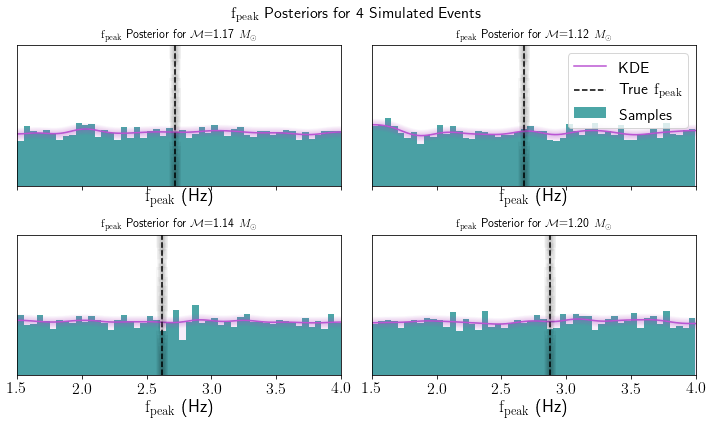

In [58]:
sim_evd = gen_simulated_eventdict(Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=fscatter,
                                  use_prior='array',prior=fprior.samples,
                                  kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                  plot='smallset',glow=True,saveto=None,showplot=True)

In [59]:
Mf_list = np.array([[sim_evd[key]['mchirp'],sim_evd[key]['ftrue']] for key in sim_evd.keys()])

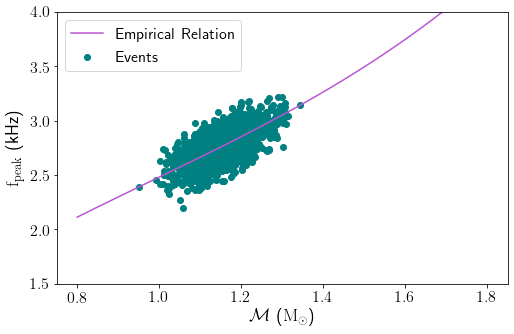

In [60]:
plt.figure()
plt.plot(Ms,empirical_relation_f(Rtrue,Ms),label='Empirical Relation')
plt.scatter(Mf_list[:,0],Mf_list[:,1],label='Events',color='teal')
plt.xlabel('$\mathcal{M}$ ($\mathrm{M_{\odot}}$)')
plt.ylabel('$\mathrm{f_{peak}}$ (kHz)')
plt.ylim(1.5,4)
plt.legend()
plt.show()

#### Run Analysis

Do a coarse grid in signal strength

In [61]:
deep_dict = {}
nsignal_vals = [5,10,25,50,100]
for i, nsignal_val in enumerate(nsignal_vals):
    print("Analyzing dataset {}/{}...".format(i+1,len(nsignal_vals)))
    deep_dict[str(nsignal_val)] = {}
    evd_i = gen_simulated_eventdict(Mlist,Rtrue,sigma_f,nsignal_val,nnoise,rng,scatter=fscatter,
                                                                 use_prior='array',prior=fprior.samples,
                                                                 kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                                                 plot=None,glow=True,saveto=None,showplot=True)
    deep_dict[str(nsignal_val)]['evd'] = evd_i
    likes_i = get_multievent_likelihoods(Rs,Ms,evd_i,Mchirp_type='simulated',fprior=fprior,
                           Mprior=st.uniform(loc=0,scale=5),Mpop_prior=st.norm(loc=1.33,scale=0.09),
                                         Mchirp_scaling='none',Mchirp_scatter='match',verbose=False,bootstrap=bootstrap)
    deep_dict[str(nsignal_val)]['likes'] = likes_i

Analyzing dataset 1/5...


100%|==========| 2000/2000 [1:17:49<00:00,  2.33s/it]


Analyzing dataset 2/5...


100%|==========| 2000/2000 [1:17:41<00:00,  2.33s/it]


Analyzing dataset 3/5...


100%|==========| 2000/2000 [1:17:53<00:00,  2.34s/it]


Analyzing dataset 4/5...


100%|==========| 2000/2000 [1:17:41<00:00,  2.33s/it]


Analyzing dataset 5/5...


100%|==========| 2000/2000 [1:17:51<00:00,  2.34s/it]


In [62]:
# with open('./paper_data/model_validation_data/2k_event_synthetic_multiSNR.pickle',"wb") as file:
#     dill.dump(deep_dict,file)

In [63]:
# deep_dict_backup = deep_dict ## this will get overwritten later so saving it here

In [64]:
# with open('./paper_data/model_validation_data/2k_event_synthetic_multiSNR.pickle',"rb") as file:
#     deep_dict = dill.load(file)

In [65]:
deep_scale_dict = {}
deep_scounts = [5,10,25,50,100]
N = 2000
for scount in deep_scounts:
    CL_arr = np.zeros((N,3))
    likelist = deep_dict[str(scount)]['likes']
    for i in range(N):
        CL_arr[i,:] = get_post_stats(get_posterior(Rs,get_aggregate_likelihood(likelist[:i+1]),Rprior_kernel),
                                     Rs,latex=False,verbose=False,bounds=(0.16,0.74))
    deep_scale_dict[str(scount)] = CL_arr

In [66]:
start = (deep_scale_dict[str(5)][:,2] - deep_scale_dict[str(5)][:,1])[0]

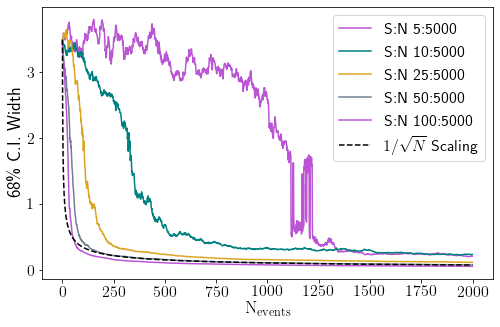

In [78]:
plt.figure()
for i, scount in enumerate(deep_scounts):
    plt.plot(deep_scale_dict[str(scount)][:,2] - deep_scale_dict[str(scount)][:,1],label="S:N {}:5000".format(scount))
plt.plot(start/np.sqrt(np.linspace(1,N,N)),label="$1/\sqrt{N}$ Scaling",color='k',ls='--')
plt.legend()#bbox_to_anchor=(0.95,1))
plt.ylabel("68\% C.I. Width")
plt.xlabel("$\mathrm{N_{events}}$")
plt.show()

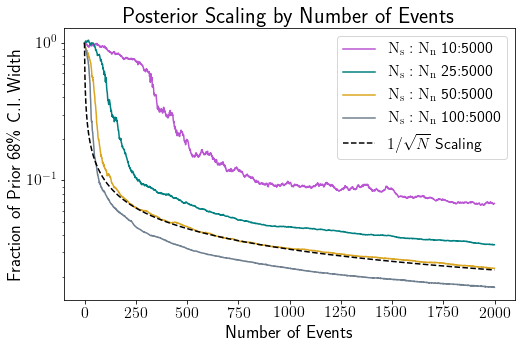

In [82]:
start = (deep_scale_dict[str(5)][:,2] - deep_scale_dict[str(5)][:,1])[0]
plt.figure()
goodkeys = [key for key in deep_scale_dict.keys() if key not in ['5']]
for key in goodkeys:
    plt.plot((deep_scale_dict[key][:,2] - deep_scale_dict[key][:,1])/start,label="$\mathrm{N_s:N_n}$"+" {}:5000".format(key))
plt.plot(1/np.sqrt(np.linspace(1,N,N)),label="$1/\sqrt{N}$ Scaling",color='k',ls='--')
plt.legend(loc='upper right',fontsize=16)
plt.ylabel("Fraction of Prior 68\% C.I. Width")
plt.xlabel("Number of Events")
plt.yscale('log')
plt.title("Posterior Scaling by Number of Events")#$\mathrm{N_{events}}$")
# plt.tight_layout()
# plt.yticks('log')
# plt.savefig('./figures/post_scale68_2k.png',bbox_inches='tight')
# plt.savefig('./figures/post_scale68_2k.pdf',bbox_inches='tight')
plt.show()

In [68]:
## combine
scaling_data_dict = {}
scaling_data_dict['events'] = deep_dict
scaling_data_dict['CI_scaling'] = deep_scale_dict

In [83]:
## save!!
with open('./paper_data/model_validation_data/2000_event_synthetic_multiSNR_scaling.pickle','wb') as file:
    dill.dump(scaling_data_dict,file)

## Contamination
Experiment: what happens if a portion (say half!) of the events have no info whatsoever?

#### Generate Events

In [84]:
## set parameters
Rtrue = 12.5
sigma_f = 0.1
nsignal = 50
nnoise = 5000

In [85]:
## get random selection of chirp masses
## for kicks, let's use the same Mchirp prior as Petrov+2021 (which in turn is that of LRR)
N = 1000
m1s = st.norm.rvs(loc=1.33,scale=0.09,size=N,random_state=rng)
m2s = st.norm.rvs(loc=1.33,scale=0.09,size=N,random_state=rng)
Mlist = calc_Mchirp(m1s,m2s)

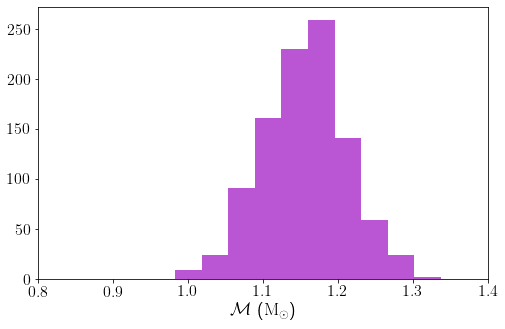

In [86]:
plt.figure()
plt.hist(Mlist)
plt.xlim(0.8,1.4)
plt.xlabel('$\mathcal{M}$ ($\mathrm{M_{\odot}}$)')
plt.show()

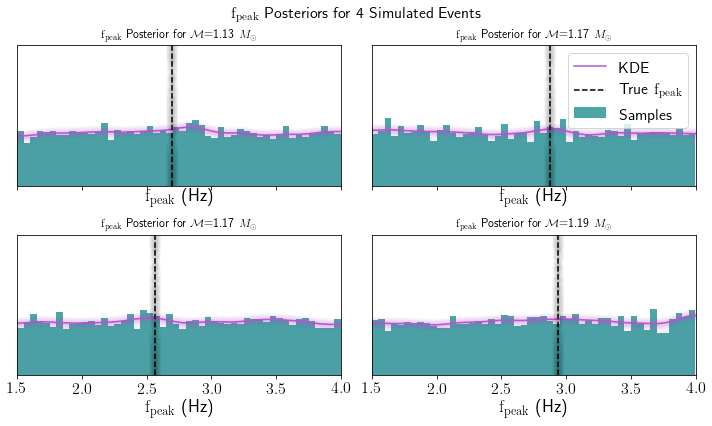

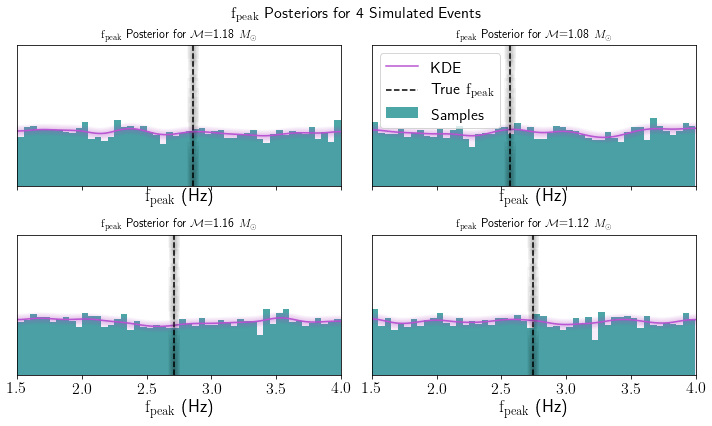

In [87]:
## half of the events, randomly drawn, will have a signal; the rest will not
good_idx = rng.choice(np.arange(N),size=500,replace=False)
good_Mlist = Mlist[good_idx]
empty_Mlist = np.delete(Mlist,good_idx)
good_evd = gen_simulated_eventdict(good_Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=fscatter,
                                  use_prior='array',prior=fprior.samples,
                                  kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                  plot='smallset',glow=True,saveto=None,showplot=True)
empty_evd = gen_simulated_eventdict(empty_Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=fscatter,
                                  use_prior='array',prior=fprior.samples,
                                  kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                  plot='smallset',glow=True,saveto=None,showplot=True,
                                   nosignal=True)

In [88]:
good_Mf_list = np.array([[good_evd[key]['mchirp'],good_evd[key]['ftrue']] for key in good_evd.keys()])
empty_Mf_list = np.array([[empty_evd[key]['mchirp'],empty_evd[key]['ftrue']] for key in empty_evd.keys()])

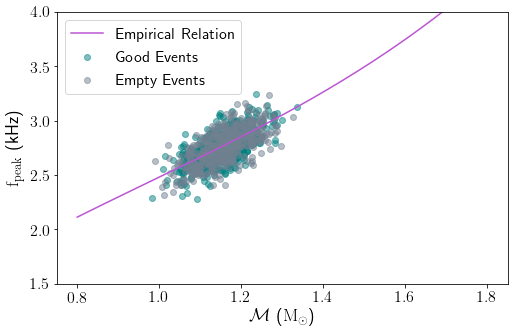

In [89]:
plt.figure()
plt.plot(Ms,empirical_relation_f(Rtrue,Ms),label='Empirical Relation')
plt.scatter(good_Mf_list[:,0],good_Mf_list[:,1],label='Good Events',color='teal',alpha=0.5)
plt.scatter(empty_Mf_list[:,0],empty_Mf_list[:,1],label='Empty Events',color='slategrey',alpha=0.5)
plt.xlabel('$\mathcal{M}$ ($\mathrm{M_{\odot}}$)')
plt.ylabel('$\mathrm{f_{peak}}$ (kHz)')
plt.ylim(1.5,4)
plt.legend()
plt.show()

In [90]:
len(good_evd),len(empty_evd)

(500, 500)

In [91]:
mixed_evd = good_evd.copy()
for key in empty_evd.keys():
    if key in mixed_evd.keys():
        mixed_evd[key+'-empty'] = empty_evd[key]
    else:
        mixed_evd[key] = empty_evd[key]

In [93]:
mixed_likes = get_multievent_likelihoods(Rs,Ms,mixed_evd,Mchirp_type='simulated',fprior=fprior,
                           Mprior=st.uniform(loc=0,scale=5),Mpop_prior=st.norm(loc=1.33,scale=0.09),
                                         Mchirp_scaling='none',Mchirp_scatter='match',verbose=False,bootstrap=bootstrap)

100%|==========| 1000/1000 [42:32<00:00,  2.55s/it]


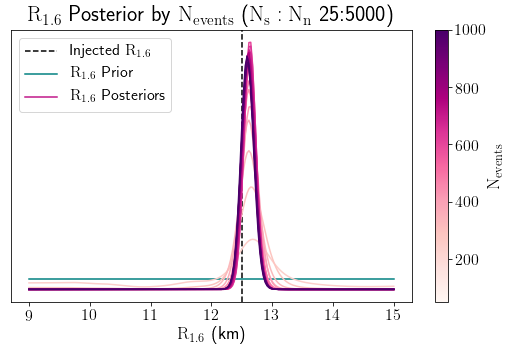

In [94]:
cmap = matplotlib.cm.get_cmap('RdPu')

plt.figure()
plt.xlabel('$\mathrm{R_{1.6}}$ (km)')#,labelpad=-1)
plt.title('$\mathrm{R_{1.6}}$ Posterior by $\mathrm{N_{events}}$ ($\mathrm{N_s:N_n}$ 25:5000)')
plt.axvline(Rtrue,ls='--',color='k',label='Injected $\mathrm{R_{1.6}}$')
plt.plot(Rs,Rprior_kernel.pdf(Rs)/np.sum(Rprior_kernel.pdf(Rs)),label='$\mathrm{R_{1.6}}$ Prior',color='teal')
# for like_i in noise_likelist:
#     plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(like_i),Rprior_kernel),color='slategray',
#              alpha=0.7,label='_nolegend_')
for i in np.arange(51,1002,50):
    colnum = (i+200)/1201
    plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(mixed_likes[:i]),Rprior_kernel),
             color=cmap(colnum),label='_nolegend_')
# orchid_line = mlines.Line2D([], [], color='mediumorchid',
#                             label='$\mathrm{R_{1.6}}$'+' Posterior')
orchid_line = mlines.Line2D([], [], color=cmap(0.7),
                            label='$\mathrm{R_{1.6}}$'+' Posteriors')
# teal_line = mlines.Line2D([], [], color='slategray',alpha=0.7,label='Noise-only $\mathrm{R_{1.6}}$ Posteriors')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles+[orchid_line],loc='upper left')#,bbox_to_anchor=(1,1))
norm = matplotlib.colors.Normalize(vmin=0, vmax=1200)
mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_clim(50,1000)
cbar = plt.colorbar(mappable,
             orientation='vertical', label='$\mathrm{N}_{\mathrm{events}}$',fraction=0.06)
# cbar.set_clim(50,1000)
# plt.colorbar()
plt.gca().set_yticks([])
# plt.tight_layout()
# plt.savefig('./paper/figures/post_Nevents_1k.pdf',bbox_inches='tight')
# plt.savefig('./paper/figures/post_Nevents_1k.png',bbox_inches='tight')
plt.show()

In [95]:
## shuffle to remove ordering
CL_arr = np.zeros((N,3))
like_idxs = rng.choice(N,replace=False,size=N)
likelist_shuff = [mixed_likes[idx] for idx in like_idxs]
for i in range(N):
    like_i = likelist_shuff[i]
    if i==0:
        agg = get_aggregate_likelihood([like_i])
    else:
        agg = get_aggregate_likelihood([agg_prev,like_i])
    agg_prev = agg
    CL_arr[i,:] = get_post_stats(get_posterior(Rs,agg,Rprior_kernel),
                                 Rs,latex=False,verbose=False,bounds=(0.16,0.74))
CL_arr_500 = CL_arr

In [96]:
shuffle_start_500 = (CL_arr_500[:,2] - CL_arr_500[:,1])[0]

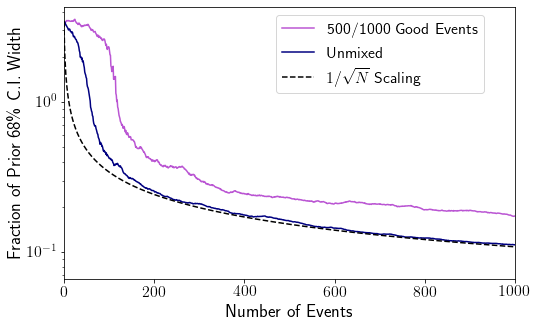

In [98]:
plt.figure()
plt.plot(CL_arr_500[:,2] - CL_arr_500[:,1],label="{}/1000 Good Events".format(500))
plt.plot(deep_scale_dict['50'][:,2] - deep_scale_dict['50'][:,1],label="Unmixed",color='navy')
plt.plot(shuffle_start_500/np.sqrt(np.linspace(1,N,N)),label="$1/\sqrt{N}$ Scaling",color='k',ls='--')
plt.legend(bbox_to_anchor=(0.95,1))
plt.xlim(0,1000)
plt.ylabel("Fraction of Prior 68\% C.I. Width")
plt.xlabel("Number of Events")
plt.yscale('log')
plt.show()
    

Let's look at the scaling of this!

In [100]:
contamination_dict = {}
contamination_dict['500'] = {}
contamination_dict['500']['likes'] = mixed_likes
N_vals = [50,100,250,750]
for i, N_good in enumerate(N_vals):
    print("Processing analysis {}/{}...".format(i+1,len(N_vals)))
    contamination_dict[str(N_good)] = {}
    good_idx = rng.choice(np.arange(N),size=N_good,replace=False)
    good_Mlist = Mlist[good_idx]
    empty_Mlist = np.delete(Mlist,good_idx)
    good_evd_i = gen_simulated_eventdict(good_Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=fscatter,
                                      use_prior='array',prior=fprior.samples,
                                      kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                      plot='smallset',glow=True,saveto=None,showplot=False)
    contamination_dict[str(N_good)]['good'] = good_evd_i
    empty_evd_i = gen_simulated_eventdict(empty_Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=fscatter,
                                      use_prior='array',prior=fprior.samples,
                                      kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                      plot='smallset',glow=True,saveto=None,showplot=False,
                                       nosignal=True)
    contamination_dict[str(N_good)]['empty'] = empty_evd_i
    mixed_evd_i = good_evd_i.copy()
    for key in empty_evd_i.keys():
        if key in mixed_evd_i.keys():
            mixed_evd_i[key+'-empty'] = empty_evd_i[key]
        else:
            mixed_evd_i[key] = empty_evd_i[key]
    contamination_dict[str(N_good)]['mixed'] = mixed_evd_i
    mixed_likes_i = get_multievent_likelihoods(Rs,Ms,mixed_evd_i,Mchirp_type='simulated',fprior=fprior,
                           Mprior=st.uniform(loc=0,scale=5),Mpop_prior=st.norm(loc=1.33,scale=0.09),
                                         Mchirp_scaling='none',Mchirp_scatter='match',verbose=False,bootstrap=bootstrap)
    contamination_dict[str(N_good)]['likes'] = mixed_likes_i

Processing analysis 1/4...


100%|==========| 1000/1000 [39:53<00:00,  2.39s/it]


Processing analysis 2/4...


100%|==========| 1000/1000 [39:14<00:00,  2.35s/it]


Processing analysis 3/4...


100%|==========| 1000/1000 [41:09<00:00,  2.47s/it]


Processing analysis 4/4...


100%|==========| 1000/1000 [52:20<00:00,  3.14s/it]


In [101]:
## shuffle
shuffle_scale_dict = {}
shuffle_scounts = [50,100,250,500,750]
N = 1000
for mcount in shuffle_scounts:
    CL_arr = np.zeros((N,3))
    likelist = contamination_dict[str(mcount)]['likes']
    like_idxs = rng.choice(N,replace=False,size=N)
    likelist_shuff = [likelist[idx] for idx in like_idxs]
    for i in range(N):
        like_i = likelist_shuff[i]
        if i==0:
            agg = get_aggregate_likelihood([like_i])
        else:
            agg = get_aggregate_likelihood([agg_prev,like_i])
        agg_prev = agg
        CL_arr[i,:] = get_post_stats(get_posterior(Rs,agg,Rprior_kernel),
                                     Rs,latex=False,verbose=False,bounds=(0.16,0.74))
    shuffle_scale_dict[str(mcount)] = CL_arr

In [102]:
shuffle_start = (shuffle_scale_dict[str(500)][:,2] - shuffle_scale_dict[str(500)][:,1])[0]

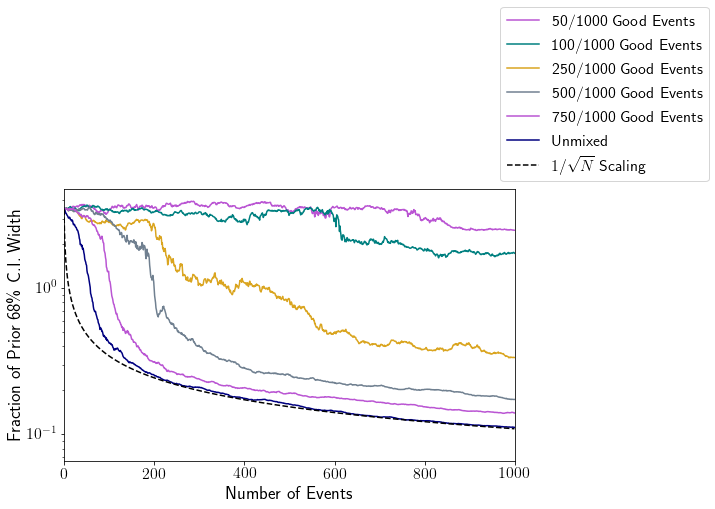

In [103]:
plt.figure()
for i, mcount in enumerate([50,100,250,500,750]):
    plt.plot(shuffle_scale_dict[str(mcount)][:,2] - shuffle_scale_dict[str(mcount)][:,1],
             label="{}/1000 Good Events".format(mcount))
plt.plot(deep_scale_dict['50'][:,2] - deep_scale_dict['50'][:,1],label="Unmixed",color='navy')
plt.plot(shuffle_start/np.sqrt(np.linspace(1,N,N)),label="$1/\sqrt{N}$ Scaling",color='k',ls='--')
plt.legend(bbox_to_anchor=(0.95,1))
plt.xlim(0,1000)
plt.ylabel("Fraction of Prior 68\% C.I. Width")
plt.xlabel("Number of Events")
plt.yscale('log')
plt.show()
    

In [104]:
mixdict = {}
mixdict['events'] = contamination_dict
mixdict['scaling'] = shuffle_scale_dict

In [105]:
## save!!
with open('./paper_data/model_validation_data/1000_event_synthetic_contamination.pickle','wb') as file:
    dill.dump(mixdict,file)